In [1]:
import os
import sys
import time
import pickle

from os import listdir
from os.path import isfile, join

from functools import partial

import pandas as pd
import numpy as np

from multiprocessing import Pool

from sklearn.datasets import load_digits

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

from script.image import load_train_resized

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf
print("Tensorflow is installed and is version: ",  tf.__version__)

%matplotlib inline

Tensorflow is installed and is version:  1.3.0


#### Load the labels

In [2]:
labels_df = pd.read_csv('labels.csv')
print(labels_df.shape)

(10222, 2)


In [3]:
labels_df.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [4]:
breeds = labels_df.breed.unique()
print('Total of %d unique breeds' % len(breeds))
print('-------------------------')
print(breeds)

Total of 120 unique breeds
-------------------------
['boston_bull' 'dingo' 'pekinese' 'bluetick' 'golden_retriever'
 'bedlington_terrier' 'borzoi' 'basenji' 'scottish_deerhound'
 'shetland_sheepdog' 'walker_hound' 'maltese_dog' 'norfolk_terrier'
 'african_hunting_dog' 'wire-haired_fox_terrier' 'redbone'
 'lakeland_terrier' 'boxer' 'doberman' 'otterhound' 'standard_schnauzer'
 'irish_water_spaniel' 'black-and-tan_coonhound' 'cairn' 'affenpinscher'
 'labrador_retriever' 'ibizan_hound' 'english_setter' 'weimaraner'
 'giant_schnauzer' 'groenendael' 'dhole' 'toy_poodle' 'border_terrier'
 'tibetan_terrier' 'norwegian_elkhound' 'shih-tzu' 'irish_terrier' 'kuvasz'
 'german_shepherd' 'greater_swiss_mountain_dog' 'basset'
 'australian_terrier' 'schipperke' 'rhodesian_ridgeback' 'irish_setter'
 'appenzeller' 'bloodhound' 'samoyed' 'miniature_schnauzer'
 'brittany_spaniel' 'kelpie' 'papillon' 'border_collie' 'entlebucher'
 'collie' 'malamute' 'welsh_springer_spaniel' 'chihuahua' 'saluki' 'pug'
 '

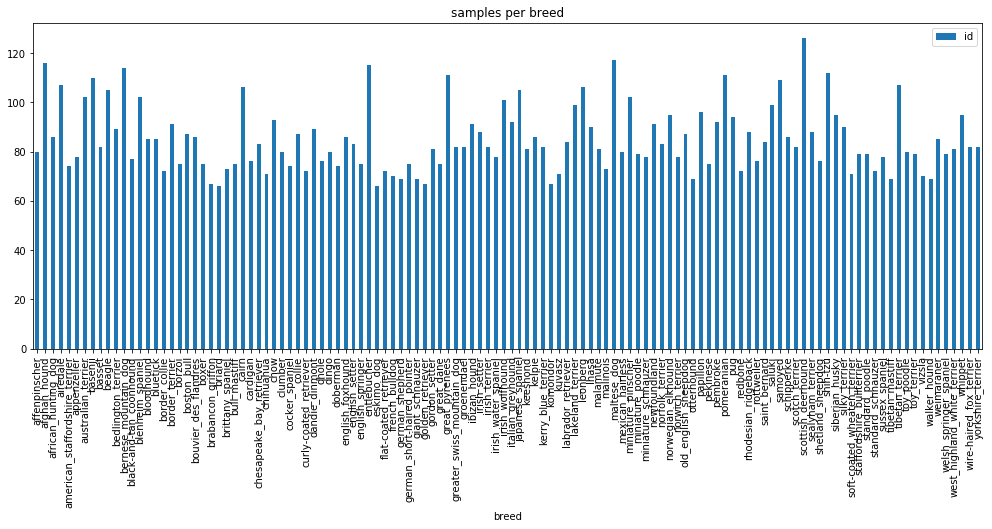

In [5]:
p = labels_df.groupby('breed').count().plot.bar(title='samples per breed', figsize=(17, 6))

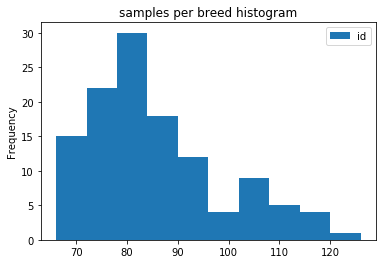

In [6]:
p = labels_df.groupby('breed').count().plot.hist(title='samples per breed histogram')

it looks like we have a balanced dataset, most of the breeds represented by 80 samples with some represented with as many as 120 and some as less as 70.

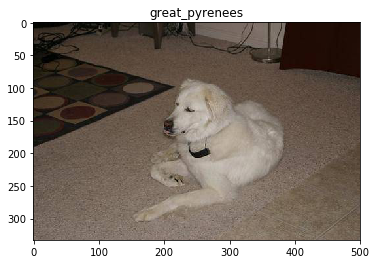

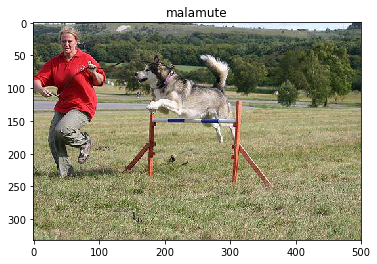

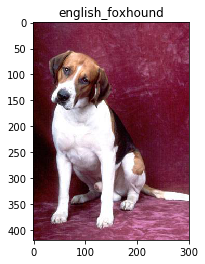

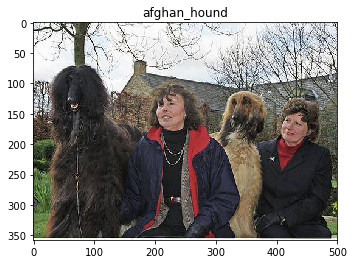

In [7]:
sample_df = labels_df.sample(4, random_state = 102)

for index, row in sample_df.iterrows():
    plt.figure()
    img=mpimg.imread('train/' + row['id'] + '.jpg')
    imgplot=plt.imshow(img)
    plt.title(row['breed'])

1. Some images have multiple dogs.
2. Some images have people and other objects.
3. Some images are different sizes.

Load images on multiple threads, the loading method has to be defined outside the notebook or it does not work.  
It also scales images to (224, 224, 3).

In [8]:
def load_images(folder, names, h, w):
    load_image = partial(load_train_resized, folder=folder, h=h, w=w)
    
    with Pool(6) as p:
        rs = p.map_async(load_image, names)
        p.close()
        while (True):
            if (rs.ready()): break
            remaining = rs._number_left
            print("Waiting for", remaining, "tasks to complete...")
            time.sleep(10)
    print('Finished loading images...')
    
    images = []
    for r in rs.get():
        images.append(r)
    return np.asarray(images)

In [9]:
train_ids = list(labels_df.id)
train_features = load_images('train', train_ids, 224, 224)
print('Features shape ', train_features.shape)

Waiting for 24 tasks to complete...
Waiting for 24 tasks to complete...
Waiting for 18 tasks to complete...
Waiting for 12 tasks to complete...
Waiting for 12 tasks to complete...
Waiting for 6 tasks to complete...
Finished loading images...
Features shape  (10222, 224, 224, 3)


In [10]:
binarizer = LabelBinarizer()
labels = binarizer.fit_transform(labels_df.breed)
print('Labels shape ', labels.shape)

Labels shape  (10222, 120)


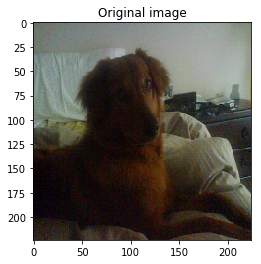

In [11]:
plt.imshow(train_features[1000])
plt.title('Original image')

In [12]:
train_features_mean = np.mean(train_features, axis=(0))
print(train_features_mean.shape)

(224, 224, 3)


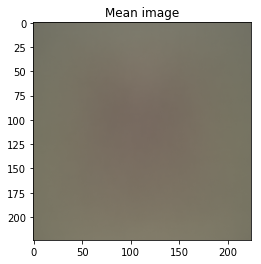

In [13]:
plt.imshow(train_features_mean)
plt.title('Mean image')

In [14]:
train_features_centered = train_features - train_features_mean

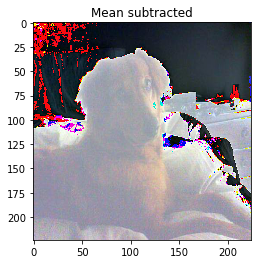

In [15]:
plt.imshow(train_features_centered[1000])
plt.title('Mean subtracted')

In [16]:
# stratify to make sure the labels are properly represented
F_train, F_test, l_train, l_test = train_test_split(
    train_features_centered, labels, test_size=0.20, stratify = labels_df.breed, random_state = 442)

In [17]:
print('Train label matrix shape:', l_train.shape)
print('Train predictor matrix shape:', F_train.shape)
print('Test label matrix shape:', l_test.shape)
print('Test predictor matrix shape:', F_test.shape)

Train label matrix shape: (8177, 120)
Train predictor matrix shape: (8177, 224, 224, 3)
Test label matrix shape: (2045, 120)
Test predictor matrix shape: (2045, 224, 224, 3)


In [18]:
def accuracy(pred_labels, true_labels):
    N = pred_labels.shape[0]
    return (100.0 * np.sum(np.argmax(pred_labels, 1) == np.argmax(true_labels, 1)) / N)

In [19]:
def plot_results(losses, train_acc, valid_acc):
    fig, ax1 = plt.subplots(figsize=(12, 6))

    ax1.set_ylabel('loss', color='b')
    ax1.tick_params('y', colors='b')
    ax1.plot(losses, 'b:')

    ax2 = ax1.twinx()
    ax2.set_ylabel('accuracy', color='r')
    ax2.tick_params('y', colors='r')
    ax2.plot(train_acc, 'r--', label='train')
    ax2.plot(valid_acc, 'r-', label='valid')
    ax2.legend(loc=0)

    fig.tight_layout()

Base class for a convolutional neural network

In [20]:
class CNN(object):
    def __init__(self, name, image_h, image_w, image_d, labels_size):
        
        self.name = name
        self.loss = None
        self.optimizer = None
        self.train_prediction = None
        self.test_prediction = None

        tf.reset_default_graph()
        tf.set_random_seed(100)
        np.random.seed(100)
        
        self.graph = tf.Graph()
        with self.graph.as_default():
            # create input variables
            self.X_train = tf.placeholder(tf.float32, shape=(None, image_h, image_w, image_d), name="TrainingData")
            self.y_train = tf.placeholder(tf.float32, shape=(None, labels_size), name="TrainingLabels")
            self.X_test  = tf.placeholder(tf.float32, shape=(None, image_h, image_w, image_d), name="TestingData")

    def create_layer(self, kernel_shape, bias_shape):
        weights = tf.get_variable('weights', kernel_shape, tf.float32, tf.truncated_normal_initializer())
        biases = tf.get_variable('biases', bias_shape, tf.float32, tf.constant_initializer(0.0))
        return (weights, biases) 
    
    def get_offset(self, X, y, batch_size, step):
        offset = (step * batch_size) % (y.shape[0] - batch_size)
        return X[offset:(offset + batch_size), :], y[offset:(offset + batch_size), :]

    def train(
        self, X, y, batch_size = 128, num_steps = 1000, report = 100, valid_size = 0.1, verbose = 1):

        X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = valid_size, random_state=100)

        with tf.Session(graph = self.graph) as session:
            
            saver = tf.train.Saver()

            tf.global_variables_initializer().run() 

            merged = tf.summary.merge_all()  
            writer = tf.summary.FileWriter("tensorflowlogs", session.graph)
                       
            losses = []
            train_acc = []
            valid_acc = []

            for step in range(num_steps):
                X_batch, y_batch = self.get_offset(X_train, y_train, batch_size, step)
                
                _, loss_value, predictions = session.run(
                    fetches = [self.optimizer, self.loss, self.train_prediction],
                    feed_dict = {self.X_train : X_batch, self.y_train : y_batch}
                )

                if (step % report == 0):
                    losses.append(loss_value)
                    train_acc.append(accuracy(predictions, y_batch))
                    valid_acc.append(accuracy(self.__predict(session, X_valid, batch_size), y_valid))

                    if (verbose > 0):
                        print('Minibatch loss at step %d: %f' % (step, loss_value))
                        print('Minibatch accuracy: %.1f%%' % train_acc[-1])
                        print('Validation accuracy: %.1f%%' % valid_acc[-1])
                
            saver.save(session, 'models/' + self.name + '.ckpt') 
            return losses, train_acc, valid_acc 
    
    def __predict(self, session, X, batch_size = 64):
        p = None
        sample_size = X.shape[0]
        total_batches = int(np.ceil(sample_size/batch_size))
        for batch_num in range(total_batches): 
            X_batch = X[batch_num*batch_size:(batch_num + 1)*batch_size]
            feed_dict = {self.X_test : X_batch}
            y_batch = np.array(session.run(self.test_prediction, feed_dict))
            if(p is None):
                p = np.array(y_batch)
            else:
                p = np.vstack((p, y_batch))
        return p
            
    def predict(self, X, batch_size = 64):
        with tf.Session(graph = self.graph) as session:
            saver = tf.train.Saver()
            saver.restore(session, 'models/' + self.name + '.ckpt')
            return self.__predict(session, X, batch_size)

CNN model with three hidden layers and three convolution layers with max pooling

In [21]:
class CNN1(CNN):
    def __init__(
        self, name, image_h, image_w, image_d, labels_size, 
        cnn1_size, cnn1_depth, cnn2_size, cnn2_depth, cnn3_size, cnn3_depth, conv_output_size,
        hidden_size1, hidden_size2, hidden_size3):

        CNN.__init__(self, name, image_h, image_w, image_d, labels_size)
        
        with self.graph.as_default():
            with tf.variable_scope("cnn1"):
                self.cnn1_weights, self.cnn1_biases = self.create_layer(
                    [cnn1_size, cnn1_size, image_d, cnn1_depth], [cnn1_depth])
            with tf.variable_scope("cnn2"):
                self.cnn2_weights, self.cnn2_biases = self.create_layer(
                    [cnn2_size, cnn2_size, cnn1_depth, cnn2_depth], [cnn2_depth])
            with tf.variable_scope("cnn3"):
                self.cnn3_weights, self.cnn3_biases = self.create_layer(
                    [cnn3_size, cnn3_size, cnn2_depth, cnn3_depth], [cnn3_depth])
            
            with tf.variable_scope("layer1"):
                self.l1_weights, self.l1_biases = self.create_layer([conv_output_size, hidden_size1], [hidden_size1])
                self.beta1 = tf.Variable(tf.zeros([hidden_size1]))
                self.scale1 = tf.Variable(tf.ones([hidden_size1]))
                
            with tf.variable_scope("layer2"):
                self.l2_weights, self.l2_biases = self.create_layer([hidden_size1, hidden_size2], [hidden_size2])
                self.beta2 = tf.Variable(tf.zeros([hidden_size2]))
                self.scale2 = tf.Variable(tf.ones([hidden_size2]))

            with tf.variable_scope("layer3"):
                self.l3_weights, self.l3_biases = self.create_layer([hidden_size2, hidden_size3], [hidden_size3])
                self.beta3 = tf.Variable(tf.zeros([hidden_size3]))
                self.scale3 = tf.Variable(tf.ones([hidden_size3]))
                
            with tf.variable_scope("layer4"):
                self.l4_weights, self.l4_biases = self.create_layer([hidden_size3, labels_size], [labels_size])

            self.logits = self.create_model(self.X_train, name="logits")
            self.train_prediction = tf.nn.softmax(self.logits)
            self.test_prediction =  tf.nn.softmax(self.create_model(self.X_test, name="testing"))                 
            self.loss = tf.reduce_mean(
                tf.nn.softmax_cross_entropy_with_logits(logits = self.logits, labels = self.y_train), name="loss")
            self.optimizer = tf.train.AdamOptimizer().minimize(self.loss)
            
    def create_model(self, data, name):
        
        epsilon = 1e-3
        
        with tf.name_scope(name) as scope:
            
            x = tf.nn.bias_add(
                tf.nn.conv2d(data, self.cnn1_weights, strides = [1, 1, 1, 1], padding='SAME'), 
                self.cnn1_biases,
                name="conv1"
            )
            
            x = tf.nn.relu(x, name = 'relu1')
            
            x = tf.nn.max_pool(
                x, 
                ksize=[1, 2, 2, 1], 
                strides=[1, 2, 2, 1], 
                padding='VALID', 
                name="pool1")
            
            x = tf.nn.bias_add(
                tf.nn.conv2d(x, self.cnn2_weights, strides = [1, 1, 1, 1], padding='SAME'), 
                self.cnn2_biases, 
                name="conv2")
            
            x = tf.nn.relu(x, name = 'relu2')
            
            x = tf.nn.max_pool(
                x, 
                ksize=[1, 2, 2, 1],
                strides=[1, 2, 2, 1], 
                padding='VALID', 
                name="pool2")

            x = tf.nn.bias_add(
                tf.nn.conv2d(x, self.cnn3_weights, strides = [1, 1, 1, 1], padding='SAME'), 
                self.cnn3_biases, 
                name="conv3")
            
            x = tf.nn.relu(x, name = 'relu3')
            
            x = tf.nn.max_pool(
                x, 
                ksize=[1, 2, 2, 1],
                strides=[1, 2, 2, 1], 
                padding='VALID', 
                name="pool3")
            
            # flatten the output of the convolution layer
            x = tf.reshape(x, shape=[tf.shape(x)[0], -1], name='flat1')
            
            x = tf.nn.bias_add(tf.matmul(x, self.l1_weights), self.l1_biases, name="layer1")
            
            batch_mean1, batch_var1 = tf.nn.moments(x,[0])
            x = tf.nn.batch_normalization(x, batch_mean1, batch_var1, self.beta1, self.scale1, epsilon)
            
            x = tf.nn.relu(x, name="relu4")
            
            x = tf.nn.bias_add(tf.matmul(x, self.l2_weights), self.l2_biases, name="layer2")
            
            batch_mean2, batch_var2 = tf.nn.moments(x,[0])
            x = tf.nn.batch_normalization(x, batch_mean2, batch_var2, self.beta2, self.scale2, epsilon)
        
            x = tf.nn.relu(x, name="relu5")

            x = tf.nn.bias_add(tf.matmul(x, self.l3_weights), self.l3_biases, name="layer3")
            
            batch_mean3, batch_var3 = tf.nn.moments(x,[0])
            x = tf.nn.batch_normalization(x, batch_mean3, batch_var3, self.beta3, self.scale3, epsilon)

            x = tf.nn.relu(x, name="relu6")
            
            x = tf.nn.bias_add(tf.matmul(x, self.l4_weights), self.l4_biases, name="layer4")

            return x

In [22]:
cnn1 = CNN1(
    'cnn1',
    image_h = 224, 
    image_w = 224, 
    image_d = 3, 
    labels_size = 120, 
    cnn1_size = 3,
    cnn1_depth = 32,
    cnn2_size = 3, 
    cnn2_depth = 64,
    cnn3_size = 3, 
    cnn3_depth = 128, 
    conv_output_size = 100352,
    hidden_size1 = 1024, 
    hidden_size2 = 1024,
    hidden_size3 = 1024)

In [23]:
losses_1, train_acc_1, valid_acc_1 = cnn1.train(F_train, l_train)

Minibatch loss at step 0: 51.141575
Minibatch accuracy: 0.0%
Validation accuracy: 0.9%
Minibatch loss at step 100: 18.030083
Minibatch accuracy: 15.6%
Validation accuracy: 1.8%
Minibatch loss at step 200: 2.374125
Minibatch accuracy: 66.4%
Validation accuracy: 2.0%
Minibatch loss at step 300: 0.411213
Minibatch accuracy: 91.4%
Validation accuracy: 1.7%
Minibatch loss at step 400: 0.082206
Minibatch accuracy: 99.2%
Validation accuracy: 2.1%
Minibatch loss at step 500: 0.004822
Minibatch accuracy: 100.0%
Validation accuracy: 2.0%
Minibatch loss at step 600: 0.001623
Minibatch accuracy: 100.0%
Validation accuracy: 2.0%
Minibatch loss at step 700: 0.003659
Minibatch accuracy: 100.0%
Validation accuracy: 2.1%
Minibatch loss at step 800: 0.000690
Minibatch accuracy: 100.0%
Validation accuracy: 1.8%
Minibatch loss at step 900: 0.004810
Minibatch accuracy: 100.0%
Validation accuracy: 2.1%


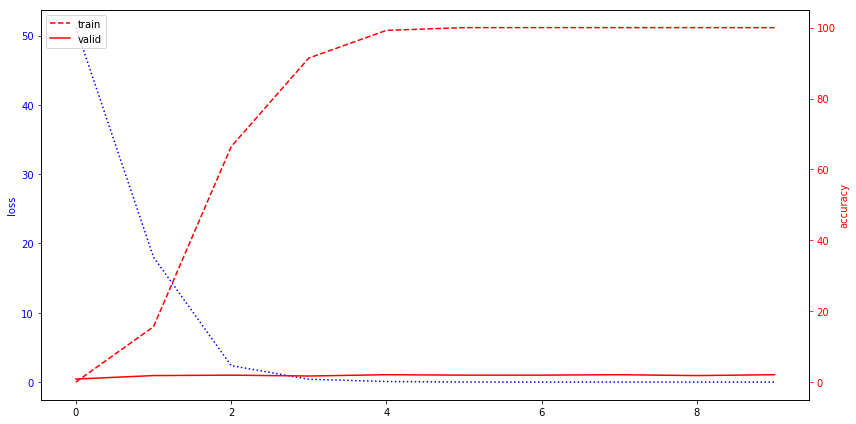

In [24]:
plot_results(losses_1, train_acc_1, valid_acc_1)

Training accuracy is up but validation accuracy is not improving. We should try regularizing the model by adding dropouts and penalizing the weights throught the loss functon.

In [25]:
class CNN2(CNN):
    def __init__(
        self, name, image_h, image_w, image_d, labels_size, 
        cnn1_size, cnn1_depth, cnn2_size, cnn2_depth, cnn3_size, cnn3_depth, conv_output_size,
        hidden_size1, hidden_size2, hidden_size3, lamb_reg):

        CNN.__init__(self, name, image_h, image_w, image_d, labels_size)
        
        with self.graph.as_default():
            
            self.keep_prob = tf.placeholder(tf.float32, name="keep_prob")

            with tf.variable_scope("cnn1"):
                self.cnn1_weights, self.cnn1_biases = self.create_layer(
                    [cnn1_size, cnn1_size, image_d, cnn1_depth], [cnn1_depth])
            with tf.variable_scope("cnn2"):
                self.cnn2_weights, self.cnn2_biases = self.create_layer(
                    [cnn2_size, cnn2_size, cnn1_depth, cnn2_depth], [cnn2_depth])
            with tf.variable_scope("cnn3"):
                self.cnn3_weights, self.cnn3_biases = self.create_layer(
                    [cnn3_size, cnn3_size, cnn2_depth, cnn3_depth], [cnn3_depth])
            
            with tf.variable_scope("layer1"):
                self.l1_weights, self.l1_biases = self.create_layer([conv_output_size, hidden_size1], [hidden_size1])
                self.beta1 = tf.Variable(tf.zeros([hidden_size1]))
                self.scale1 = tf.Variable(tf.ones([hidden_size1]))
                
            with tf.variable_scope("layer2"):
                self.l2_weights, self.l2_biases = self.create_layer([hidden_size1, hidden_size2], [hidden_size2])
                self.beta2 = tf.Variable(tf.zeros([hidden_size2]))
                self.scale2 = tf.Variable(tf.ones([hidden_size2]))

            with tf.variable_scope("layer3"):
                self.l3_weights, self.l3_biases = self.create_layer([hidden_size2, hidden_size3], [hidden_size3])
                self.beta3 = tf.Variable(tf.zeros([hidden_size3]))
                self.scale3 = tf.Variable(tf.ones([hidden_size3]))
                
            with tf.variable_scope("layer4"):
                self.l4_weights, self.l4_biases = self.create_layer([hidden_size3, labels_size], [labels_size])

            self.logits = self.create_model(self.X_train, name="logits")
            self.train_prediction = tf.nn.softmax(self.logits)
            self.test_prediction =  tf.nn.softmax(self.create_model(self.X_test, name="testing"))                 
            self.loss = tf.reduce_mean(
                tf.nn.softmax_cross_entropy_with_logits(logits = self.logits, labels = self.y_train), name="loss")
            
            regularizers = (
                tf.nn.l2_loss(self.l1_weights) + 
                tf.nn.l2_loss(self.l1_biases) + 
                tf.nn.l2_loss(self.l2_weights) + 
                tf.nn.l2_loss(self.l2_biases) + 
                tf.nn.l2_loss(self.l3_weights) + 
                tf.nn.l2_loss(self.l3_biases)
            )
            self.loss += lamb_reg * regularizers
            self.optimizer = tf.train.AdamOptimizer().minimize(self.loss)
            
    def create_model(self, data, name):
        
        epsilon = 1e-3
        
        with tf.name_scope(name) as scope:
            
            x = tf.nn.bias_add(
                tf.nn.conv2d(data, self.cnn1_weights, strides = [1, 1, 1, 1], padding='SAME'), 
                self.cnn1_biases,
                name="conv1"
            )
            
            x = tf.nn.relu(x, name = 'relu1')
            
            x = tf.nn.max_pool(
                x, 
                ksize=[1, 2, 2, 1], 
                strides=[1, 2, 2, 1], 
                padding='VALID', 
                name="pool1")
            
            x = tf.nn.bias_add(
                tf.nn.conv2d(x, self.cnn2_weights, strides = [1, 1, 1, 1], padding='SAME'), 
                self.cnn2_biases, 
                name="conv2")
            
            x = tf.nn.relu(x, name = 'relu2')
            
            x = tf.nn.max_pool(
                x, 
                ksize=[1, 2, 2, 1],
                strides=[1, 2, 2, 1], 
                padding='VALID', 
                name="pool2")

            x = tf.nn.bias_add(
                tf.nn.conv2d(x, self.cnn3_weights, strides = [1, 1, 1, 1], padding='SAME'), 
                self.cnn3_biases, 
                name="conv3")
            
            x = tf.nn.relu(x, name = 'relu3')
            
            x = tf.nn.max_pool(
                x, 
                ksize=[1, 2, 2, 1],
                strides=[1, 2, 2, 1], 
                padding='VALID', 
                name="pool3")
            
            # flatten the output of the convolution layer
            x = tf.reshape(x, shape=[tf.shape(x)[0], -1], name='flat1')
            
            x = tf.nn.bias_add(tf.matmul(x, self.l1_weights), self.l1_biases, name="layer1")
            
            batch_mean1, batch_var1 = tf.nn.moments(x,[0])
            x = tf.nn.batch_normalization(x, batch_mean1, batch_var1, self.beta1, self.scale1, epsilon)
            
            x = tf.nn.relu(x, name="relu4")
            
            x = tf.nn.dropout(x, keep_prob = self.keep_prob, name="drop1")
            
            x = tf.nn.bias_add(tf.matmul(x, self.l2_weights), self.l2_biases, name="layer2")
            
            batch_mean2, batch_var2 = tf.nn.moments(x,[0])
            x = tf.nn.batch_normalization(x, batch_mean2, batch_var2, self.beta2, self.scale2, epsilon)
        
            x = tf.nn.relu(x, name="relu5")

            x = tf.nn.dropout(x, keep_prob = self.keep_prob, name="drop2")
            
            x = tf.nn.bias_add(tf.matmul(x, self.l3_weights), self.l3_biases, name="layer3")
            
            batch_mean3, batch_var3 = tf.nn.moments(x,[0])
            x = tf.nn.batch_normalization(x, batch_mean3, batch_var3, self.beta3, self.scale3, epsilon)

            x = tf.nn.relu(x, name="relu6")
            
            x = tf.nn.dropout(x, keep_prob = self.keep_prob, name="drop3")
            
            x = tf.nn.bias_add(tf.matmul(x, self.l4_weights), self.l4_biases, name="layer4")

            return x
        
    def train(
        self, X, y, k_prob = 1.0, batch_size = 128, num_steps = 1000, report = 100, valid_size = 0.1, verbose = 1):

        X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = valid_size, random_state=100)

        with tf.Session(graph = self.graph) as session:
            
            saver = tf.train.Saver()

            tf.global_variables_initializer().run() 

            merged = tf.summary.merge_all()  
            writer = tf.summary.FileWriter("tensorflowlogs", session.graph)
                       
            losses = []
            train_acc = []
            valid_acc = []

            for step in range(num_steps):
                X_batch, y_batch = self.get_offset(X_train, y_train, batch_size, step)
                
                _, loss_value, predictions = session.run(
                    fetches = [self.optimizer, self.loss, self.train_prediction],
                    feed_dict = {self.X_train : X_batch, self.y_train : y_batch, self.keep_prob : k_prob}
                )

                if (step % report == 0):
                    losses.append(loss_value)
                    train_acc.append(accuracy(predictions, y_batch))
                    valid_acc.append(accuracy(self.__predict(session, X_valid, batch_size), y_valid))

                    if (verbose > 0):
                        print('Minibatch loss at step %d: %f' % (step, loss_value))
                        print('Minibatch accuracy: %.1f%%' % train_acc[-1])
                        print('Validation accuracy: %.1f%%' % valid_acc[-1])
                
            saver.save(session, 'models/' + self.name + '.ckpt') 
            return losses, train_acc, valid_acc 
    
    def __predict(self, session, X, batch_size = 64):
        p = None
        sample_size = X.shape[0]
        total_batches = int(np.ceil(sample_size/batch_size))
        for batch_num in range(total_batches): 
            X_batch = X[batch_num*batch_size:(batch_num + 1)*batch_size]
            feed_dict = {self.X_test : X_batch, self.keep_prob : 1.0}
            y_batch = np.array(session.run(self.test_prediction, feed_dict))
            if(p is None):
                p = np.array(y_batch)
            else:
                p = np.vstack((p, y_batch))
        return p
            
    def predict(self, X, batch_size = 64):
        with tf.Session(graph = self.graph) as session:
            saver = tf.train.Saver()
            saver.restore(session, 'models/' + self.name + '.ckpt')
            return self.__predict(session, X, batch_size)

In [26]:
cnn2 = CNN2(
    'cnn2',
    image_h = 224, 
    image_w = 224, 
    image_d = 3, 
    labels_size = 120, 
    cnn1_size = 3,
    cnn1_depth = 32,
    cnn2_size = 3, 
    cnn2_depth = 64,
    cnn3_size = 3, 
    cnn3_depth = 128, 
    conv_output_size = 100352,
    hidden_size1 = 1024, 
    hidden_size2 = 1024,
    hidden_size3 = 1024,
    lamb_reg = 0.0001)

In [27]:
losses_2, train_acc_2, valid_acc_2 = cnn2.train(F_train, l_train, num_steps = 2000, report = 200, k_prob = 0.8)

Minibatch loss at step 0: 4113.794922
Minibatch accuracy: 0.8%
Validation accuracy: 1.0%
Minibatch loss at step 200: 3477.541016
Minibatch accuracy: 6.2%
Validation accuracy: 2.6%
Minibatch loss at step 400: 2948.409180
Minibatch accuracy: 14.8%
Validation accuracy: 1.7%
Minibatch loss at step 600: 2507.741455
Minibatch accuracy: 19.5%
Validation accuracy: 2.4%
Minibatch loss at step 800: 2137.068604
Minibatch accuracy: 28.1%
Validation accuracy: 2.7%
Minibatch loss at step 1000: 1821.903320
Minibatch accuracy: 54.7%
Validation accuracy: 3.7%
Minibatch loss at step 1200: 1553.062500
Minibatch accuracy: 59.4%
Validation accuracy: 3.8%
Minibatch loss at step 1400: 1320.326660
Minibatch accuracy: 65.6%
Validation accuracy: 3.8%
Minibatch loss at step 1600: 1118.021729
Minibatch accuracy: 73.4%
Validation accuracy: 4.3%
Minibatch loss at step 1800: 943.918579
Minibatch accuracy: 75.8%
Validation accuracy: 4.2%


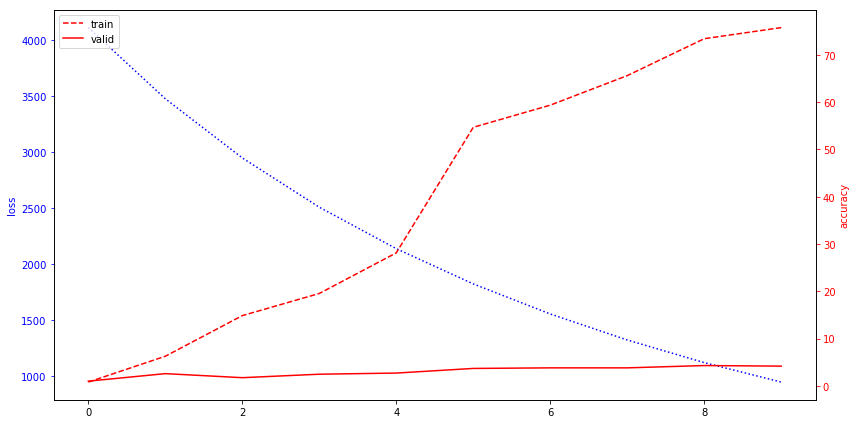

In [28]:
plot_results(losses_2, train_acc_2, valid_acc_2)

In [29]:
y_test_proba = cnn2.predict(F_test)
test_acc = accuracy(y_test_proba, l_test)

INFO:tensorflow:Restoring parameters from models/cnn2.ckpt


In [30]:
print('Test accuracy is {:.2%}'.format(test_acc/100.))

Test accuracy is 4.89%


I think this is the best I can do on ths dataset.

In [31]:
test_ids = [ os.path.splitext(f)[0] for f in listdir('test') if isfile(join('test', f))]
test_features = load_images('test', test_ids, 224, 224)
print('Features shape ', test_features.shape)

Waiting for 24 tasks to complete...
Waiting for 24 tasks to complete...
Waiting for 18 tasks to complete...
Waiting for 14 tasks to complete...
Waiting for 12 tasks to complete...
Waiting for 6 tasks to complete...
Finished loading images...
Features shape  (10357, 224, 224, 3)


In [32]:
test_features_mean = np.mean(test_features, axis=(0))
print(test_features_mean.shape)

(224, 224, 3)


In [33]:
test_features_centered = test_features - test_features_mean

In [34]:
y_pred_proba = cnn2.predict(test_features_centered)

INFO:tensorflow:Restoring parameters from models/cnn2.ckpt


Prepare the Kaggle submission

In [35]:
output_df = pd.DataFrame(y_pred_proba)
output_df.columns = binarizer.classes_
output_df.insert(loc=0, column='id', value=test_ids)
output_df.reset_index(drop=True, inplace=True)
output_df.to_csv('cnn_pred.csv',  index=False, float_format='%.7f')